In [1]:
%load_ext autoreload
%autoreload 2
import torch
import eq
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import trange, tqdm

from torch.utils.tensorboard import SummaryWriter
import datetime

In [2]:
print(eq.data.default_catalogs_dir)

/home/gcl/RA/zekai.wang/recast/data


In [3]:
catalog = eq.catalogs.ANSS_MultiCatalog(num_sequences=10000,
    t_end_days=4*365,
    mag_completeness=4.5,
    minimum_mainshock_mag=6.0,)

Loading existing catalog from /home/gcl/RA/zekai.wang/recast/data/ANSS_MultiCatalog.


/home/gcl/RA/zekai.wang/recast/eq/data/sequence.py:241: UserWarning: Found 1 zero inter-event times in the sequence. This violates fundamental assumptions of TPP models and may lead to incorrect log-likelihood values.
  warnings.warn(


In [4]:
print("Train sequence:")
print(catalog.train[0])
print("\nValidation sequence:")
print(catalog.val[0])
print("\nTest sequence:")
print(catalog.test[0])

Train sequence:
Sequence(
  inter_times: [1551],
  arrival_times: [1550],
  t_start: 0.0,
  t_end: 1460.0,
  t_nll_start: 0.0,
  mag: [1550],
  mag_bounds: [2],
  mag_nll_bounds: [2]
)

Validation sequence:
Sequence(
  inter_times: [2145],
  arrival_times: [2144],
  t_start: 0.0,
  t_end: 1460.0,
  t_nll_start: 0.0,
  mag: [2144],
  mag_bounds: [2],
  mag_nll_bounds: [2]
)

Test sequence:
Sequence(
  inter_times: [1793],
  arrival_times: [1792],
  t_start: 0.0,
  t_end: 1348.007,
  t_nll_start: 0.0,
  mag: [1792],
  mag_bounds: [2],
  mag_nll_bounds: [2]
)


<Axes: xlabel='Time (days)', ylabel='Magnitude'>

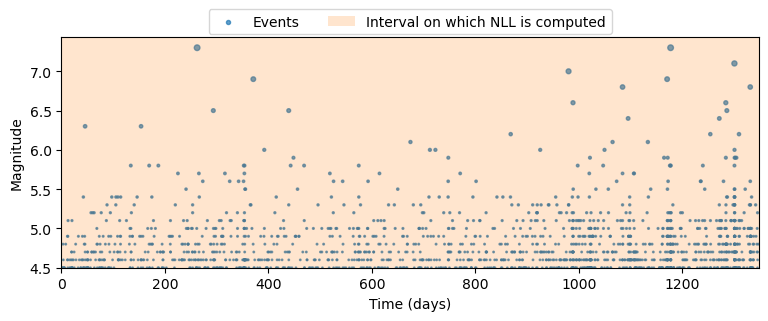

In [5]:
eq.visualization.visualize_sequence(catalog.test[0], show_nll=True)

## Training the model

In [6]:
batch_size = 32
dl_train = catalog.train.get_dataloader(batch_size=batch_size)
dl_val = catalog.val.get_dataloader(batch_size=batch_size)
dl_test = catalog.test.get_dataloader(batch_size=batch_size)

In [7]:
!nvidia-smi
gpu_number = 1
device = torch.device(f"cuda:{gpu_number}")
print(f"using {device}")

Mon Nov  6 16:13:43 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                        Off| 00000000:3B:00.0 Off |                    0 |
| N/A   45C    P0               27W /  70W|  13488MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
model = eq.models.RecurrentTPP()
model = model.to(device)

In [9]:
epochs = 100
avg_train_loss_list =[]
avg_val_loss_list = []

effective_batch_size = 32
M = effective_batch_size // batch_size

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
optimizer.zero_grad()

now = datetime.datetime.now()
writer = SummaryWriter(f"experiments/recurrent_{now}")

num_train_iters_in_one_epoch = len(dl_train)

for epoch in trange(epochs):
    running_training_loss = []
    model.train()
    for i, data in enumerate(tqdm(dl_train)):
        data = data.to(device)
        nll = model.nll_loss(data).mean() / M
        nll.backward()
        running_training_loss.append(nll.item())
        writer.add_scalar("training_loss_per_step", nll.item() * M, i + epoch * num_train_iters_in_one_epoch)
        for name, param in model.named_parameters():
            if param.grad is not None:
                writer.add_scalar(f"{name}_accumulated_gradient_norm_per_step", torch.norm(param.grad).item(), i + epoch * num_train_iters_in_one_epoch)

        if i % M == M - 1:
            torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)
            optimizer.step()
            optimizer.zero_grad()
        
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        for i, data in enumerate(dl_val):
            data = data.to(device)
            nll = model.nll_loss(data).mean()
            running_val_loss.append(nll.item())

    avg_train_loss_list.append(np.mean(running_training_loss))
    avg_val_loss_list.append(np.mean(running_val_loss))
    writer.add_scalar("avg_training_loss_per_epoch", np.mean(running_training_loss), epoch)
    writer.add_scalar("avg_validation_loss_per_epoch", np.mean(running_val_loss), epoch)
writer.close()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

In [10]:
model.eval()
with torch.no_grad():
    running_test_loss = []
    for i, data in enumerate(dl_test):
        data = data.to(device)
        nll = model.nll_loss(data).mean()
        running_test_loss.append(nll.item())
print(f"avg test loss: {np.mean(running_test_loss)}")

avg test loss: 0.41284275102236917


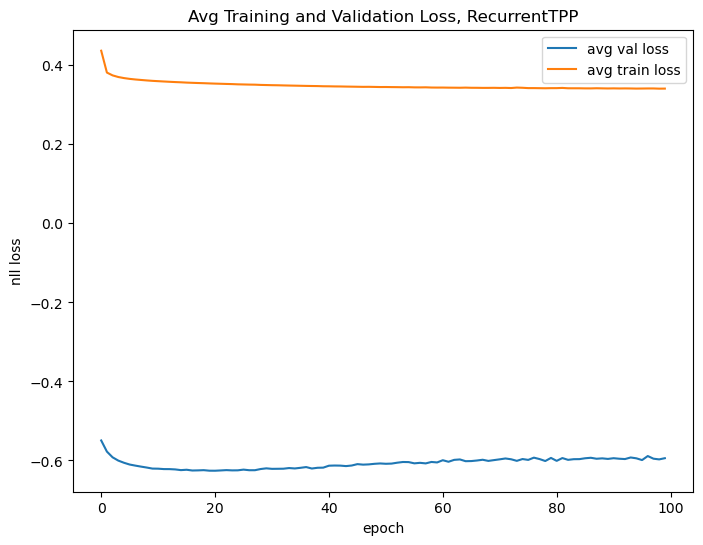

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(0, epochs), avg_val_loss_list, label="avg val loss")
ax.plot(np.arange(0, epochs), avg_train_loss_list, label="avg train loss")
ax.set_xlabel("epoch")
ax.set_ylabel("nll loss")
ax.legend()
ax.set_title("Avg Training and Validation Loss, RecurrentTPP")
plt.show()

In [12]:
torch.save(model, "trained_recurrent_tpp")